# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Project overview and our goals

You should remove any data sources or questions that are not being used and you should now have a focused discussion at the top of your notebook on what questions you will attack and a discussion of why the data you are using is correct. 


The main goal of our project is to outperform other competitors in the March Machine Learning Mania 2023 Kaggle competition. The goal of this competition is to create a model that can most accurately and confidently identify the winner of each game in the men's and women's NCAA basketball tournament. We also aim to eventually provide an interactive dashboard that will allow users to choose their own factors to see if they can outperform our design. This is a process that we would complete after participating in the competition.
 

We plan to use data from multiple external sources to improve our model past the given Kaggle data. So far, we have performed EDA on two new datasets from ESPN and FiveThirtyEight. These datsets provide different ratings for teams, so we hope to incorporate these ratings into our model.

We also plan to eventually add individual player data to further improve our model. This would allow us to include features like number of 4 and 5 star recruits on a team, for example.

In the end, we plan to combine all of these datasets into our final model that will be selected based on our testing.

Since the data for the 2023 March Maddness competition has not yet been released, we are currently working with data from the 2022 competition. Although there are some changes from 2022 (Brier score, combining men's and women's competition) the data provided should be in a very similar format. Below we have included links to 3 previos competitions.

[2019 Competition](https://www.kaggle.com/competitions/mens-machine-learning-competition-2019)

[2021 Competition](https://www.kaggle.com/competitions/ncaam-march-mania-2021)

[2022 Competition](https://www.kaggle.com/competitions/mens-march-mania-2022)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

[ESPN BPI data](https://www.espn.com/mens-college-basketball/bpi)

[FiveThirtyEight data](https://www.kaggle.com/datasets/raddar/ncaa-men-538-team-ratings)

[247 Player Rankings data](https://247sports.com/Season/2023-Basketball/RecruitRankings/)

# ETL & EDA

In [1]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  
from xgboost import XGBClassifier
from bs4 import BeautifulSoup
from fuzzywuzzy import process

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [2]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113236,2024,132,1120,86,1196,67,N,0,31,61,...,13,18,25,13,26,9,11,8,6,17
113237,2024,132,1182,57,1433,51,N,0,17,57,...,24,12,14,9,25,9,16,10,9,16
113238,2024,132,1228,93,1458,87,N,0,30,57,...,20,20,23,13,17,17,7,7,1,20
113239,2024,132,1412,85,1396,69,N,0,31,63,...,21,14,17,11,26,17,14,6,6,18



Let's check the datatypes

In [3]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [4]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

In [5]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [6]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

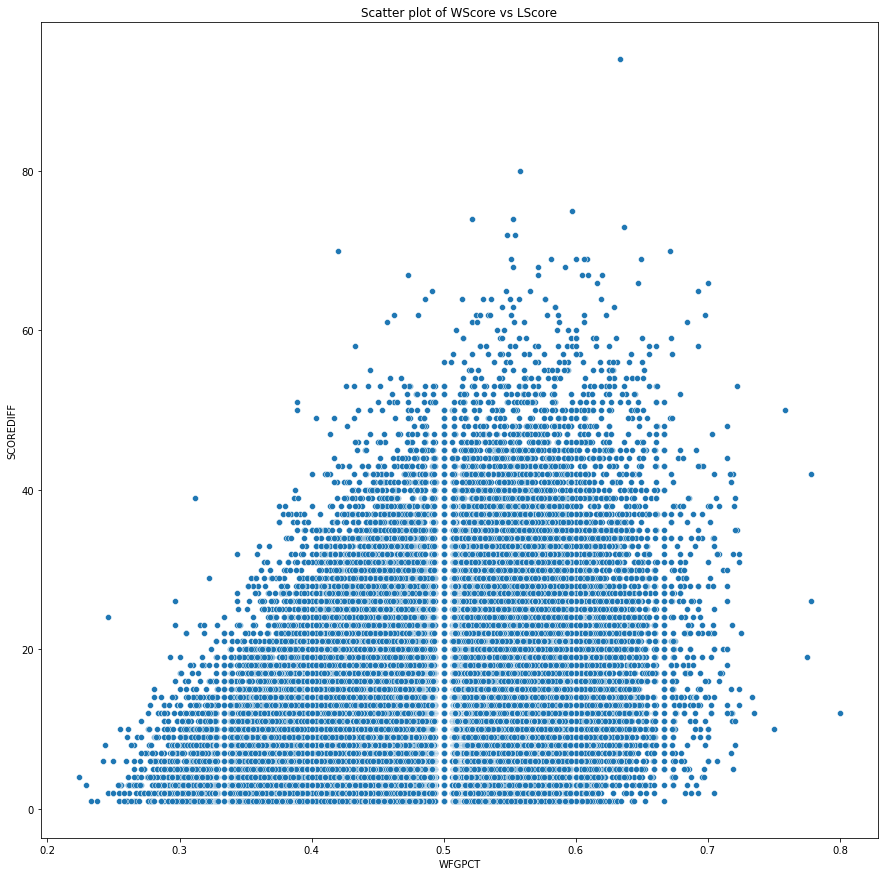

In [7]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WFGPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)
plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WFGPCT')
plt.ylabel('SCOREDIFF')
plt.show()

We can look at other factors as well:

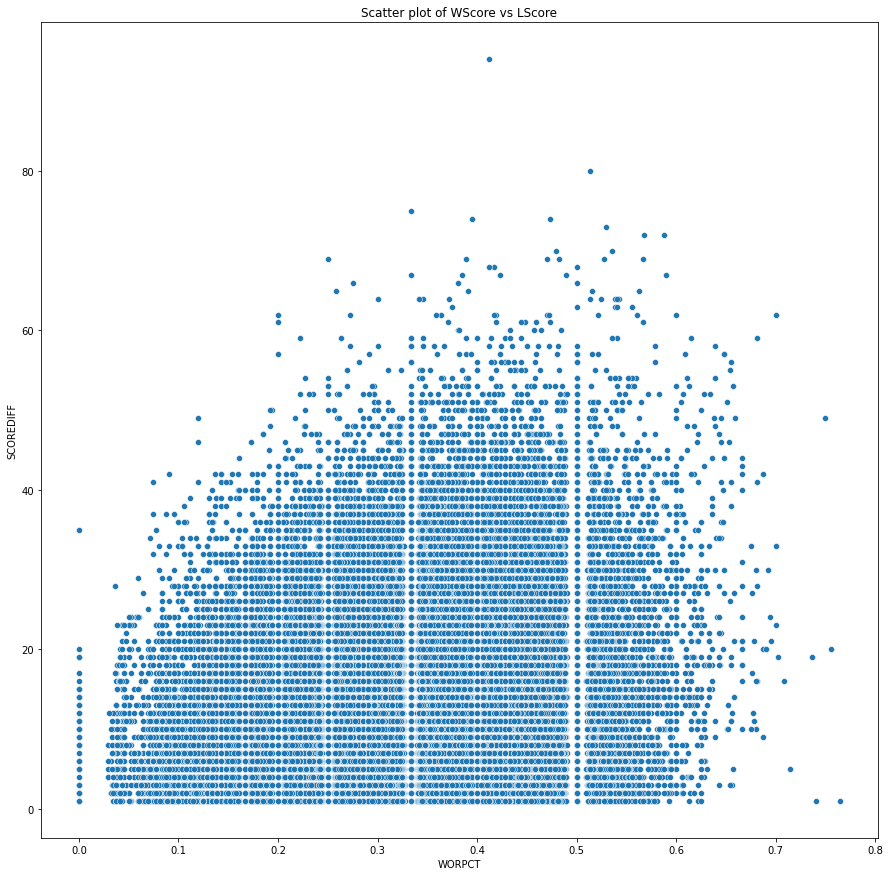

In [8]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WORPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)

plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WORPCT')
plt.ylabel('SCOREDIFF')
plt.show()

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

In [9]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,1274,88,1400,81,N,0,29,49,...,25,11,15,9,14,20,13,6,1,23
1311,2023,146,1361,57,1166,56,N,0,25,66,...,17,10,11,8,24,9,9,3,2,11
1312,2023,152,1163,72,1274,59,N,0,28,57,...,20,12,12,12,17,10,9,8,1,12
1313,2023,152,1361,72,1194,71,N,0,25,57,...,22,16,21,7,24,6,9,6,2,17


In [10]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [11]:
# Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [12]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [13]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [14]:
detailed_tourney_results.dtypes

Season          int64
DayNum          int64
WTeamID         int64
WScore          int64
LTeamID         int64
LScore          int64
WLoc           object
NumOT           int64
WFGM            int64
WFGA            int64
WFGM3           int64
WFGA3           int64
WFTM            int64
WFTA            int64
WOR             int64
WDR             int64
WAst            int64
WTO             int64
WStl            int64
WBlk            int64
WPF             int64
LFGM            int64
LFGA            int64
LFGM3           int64
LFGA3           int64
LFTM            int64
LFTA            int64
LOR             int64
LDR             int64
LAst            int64
LTO             int64
LStl            int64
LBlk            int64
LPF             int64
SCOREDIFF       int64
WFGPCT        float64
W3PCT         float64
WFTPCT        float64
WORBCHANCE      int64
WORPCT        float64
LFGPCT        float64
L3PCT         float64
LFTPCT        float64
LORBCHANCE      int64
LORPCT        float64
dtype: obj

In [15]:
detailed_tourney_results.head(1)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.37931,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702


# Creating Dataframe for Model Testing

First, we want to format a dataframe that we can use. To do this, we took the above `detailed_tourney_results` df and split it up so that each row is a team, and we added an outcome variable indicating a win or loss. This will allow us to predict an outcome per team, which is what we will ultimately be doing to the competition.

In [16]:
# Create a new data frame for winning teams
df_winning = detailed_tourney_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_tourney_results.columns if col.startswith('W')]].copy()
df_winning['Outcome'] = 1
df_winning['Outcome'] = df_winning['Outcome'].astype(int)


# Create a new data frame for losing teams
df_losing = detailed_tourney_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_tourney_results.columns if col.startswith('L')]].copy()
df_losing['Outcome'] = 0
df_losing['Outcome'] = df_losing['Outcome'].astype(int)

print("Winning Team Data Frame:")
df_winning.head()
print("\nLosing Team Data Frame:")
df_losing.head()

Winning Team Data Frame:

Losing Team Data Frame:


,Season,DayNum,NumOT,SCOREDIFF,LTeamID,LScore,LFGM,LFGA,LFGM3,LFGA3,...,LTO,LStl,LBlk,LPF,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,Outcome
0,2003,134,1,8,1411,84,29,67,12,31,...,15,5,0,22,0.432836,0.387097,0.451613,47,0.361702,0
1,2003,136,0,29,1436,51,20,64,4,16,...,17,10,3,15,0.312500,0.250000,1.000000,44,0.181818,0
2,2003,136,0,13,1272,71,25,69,7,28,...,12,2,5,18,0.362319,0.250000,0.666667,47,0.425532,0
3,2003,136,0,6,1166,73,27,60,7,17,...,21,6,6,21,0.450000,0.411765,0.705882,34,0.411765,0
4,2003,136,1,2,1301,74,25,56,9,21,...,14,5,8,19,0.446429,0.428571,0.750000,30,0.333333,0


In [17]:
# Remove the 'W' or 'L' prefix from the column names
df_winning.columns = [col[1:] if col.startswith('W') else col for col in df_winning.columns]
df_losing.columns = [col[1:] if col.startswith('L') else col for col in df_losing.columns]
# Combine the two DataFrames
combined_df = pd.concat([df_winning, df_losing], ignore_index=True)
combined_df

,Season,DayNum,NumOT,SCOREDIFF,TeamID,Score,Loc,FGM,FGA,FGM3,...,TO,Stl,Blk,PF,FGPCT,3PCT,FTPCT,ORBCHANCE,ORPCT,Outcome
0,2003,134,1,8,1421,92,N,32,69,11,...,12,5,3,22,0.463768,0.379310,0.653846,42,0.333333,1
1,2003,136,0,29,1112,80,N,31,66,7,...,16,10,7,8,0.469697,0.304348,0.785714,37,0.297297,1
2,2003,136,0,13,1113,84,N,31,59,6,...,9,7,4,19,0.525424,0.428571,0.727273,32,0.312500,1
3,2003,136,0,6,1141,79,N,29,53,3,...,18,13,1,19,0.547170,0.428571,0.720000,28,0.392857,1
4,2003,136,1,2,1143,76,N,27,64,7,...,13,8,2,14,0.421875,0.350000,0.652174,44,0.409091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,2023,146,0,7,1400,81,NaN,30,60,10,...,13,6,1,23,0.500000,0.400000,0.733333,28,0.321429,0
2626,2023,146,0,1,1166,56,NaN,22,55,2,...,9,3,2,11,0.400000,0.117647,0.909091,31,0.258065,0
2627,2023,152,0,13,1274,59,NaN,20,62,7,...,9,8,1,12,0.322581,0.350000,1.000000,39,0.307692,0
2628,2023,152,0,1,1194,71,NaN,23,52,9,...,9,6,2,17,0.442308,0.409091,0.761905,30,0.233333,0


In [18]:
mteams_df = pd.read_csv('MTeams.csv')

# Merge on 'TeamID'
combined_df = pd.merge(combined_df, mteams_df[['TeamID', 'TeamName']], on='TeamID', how='left')

# Display the resulting DataFrame
print(combined_df.head())

   Season  DayNum  NumOT  SCOREDIFF  TeamID  Score Loc  FGM  FGA  FGM3  ...  \
0    2003     134      1          8    1421     92   N   32   69    11  ...   
1    2003     136      0         29    1112     80   N   31   66     7  ...   
2    2003     136      0         13    1113     84   N   31   59     6  ...   
3    2003     136      0          6    1141     79   N   29   53     3  ...   
4    2003     136      1          2    1143     76   N   27   64     7  ...   

   Stl  Blk  PF     FGPCT      3PCT     FTPCT  ORBCHANCE     ORPCT  Outcome  \
0    5    3  22  0.463768  0.379310  0.653846         42  0.333333        1   
1   10    7   8  0.469697  0.304348  0.785714         37  0.297297        1   
2    7    4  19  0.525424  0.428571  0.727273         32  0.312500        1   
3   13    1  19  0.547170  0.428571  0.720000         28  0.392857        1   
4    8    2  14  0.421875  0.350000  0.652174         44  0.409091        1   

        TeamName  
0  UNC Asheville  
1        Ari

In [19]:
combined_df = combined_df[['TeamName', 'Season', 'Outcome', 'TeamID', 'DayNum', 'Loc', 'NumOT', 'Score', 'SCOREDIFF', 
                          'FGM', 'FGA', 'FGPCT', 'FGM3', 'FGA3', '3PCT', 'FTM', 'FTA', 'FTPCT', 'OR', 'DR', 
                          'ORBCHANCE', 'ORPCT', 'Ast', 'Stl', 'Blk', 'TO', 'PF']]

combined_df.columns

Index(['TeamName', 'Season', 'Outcome', 'TeamID', 'DayNum', 'Loc', 'NumOT',
       'Score', 'SCOREDIFF', 'FGM', 'FGA', 'FGPCT', 'FGM3', 'FGA3', '3PCT',
       'FTM', 'FTA', 'FTPCT', 'OR', 'DR', 'ORBCHANCE', 'ORPCT', 'Ast', 'Stl',
       'Blk', 'TO', 'PF'],
      dtype='object')

In [20]:
combined_df

,TeamName,Season,Outcome,TeamID,DayNum,Loc,NumOT,Score,SCOREDIFF,FGM,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,N,1,92,8,32,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1,Arizona,2003,1,1112,136,N,0,80,29,31,...,0.785714,11,36,37,0.297297,22,10,7,16,8
2,Arizona St,2003,1,1113,136,N,0,84,13,31,...,0.727273,10,27,32,0.312500,18,7,4,9,19
3,C Michigan,2003,1,1141,136,N,0,79,6,29,...,0.720000,11,20,28,0.392857,15,13,1,18,19
4,California,2003,1,1143,136,N,1,76,2,27,...,0.652174,18,20,44,0.409091,17,8,2,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,Texas,2023,0,1400,146,NaN,0,81,7,30,...,0.733333,9,14,28,0.321429,20,6,1,13,23
2626,Creighton,2023,0,1166,146,NaN,0,56,1,22,...,0.909091,8,24,31,0.258065,9,3,2,9,11
2627,Miami FL,2023,0,1274,152,NaN,0,59,13,20,...,1.000000,12,17,39,0.307692,10,8,1,9,12
2628,FL Atlantic,2023,0,1194,152,NaN,0,71,1,23,...,0.761905,7,24,30,0.233333,6,6,2,9,17


In [21]:
# Select rows where season is 2003 and DayNum is 134 as a test
selected_rows = combined_df[(combined_df['Season'] == 2003) & (combined_df['DayNum'] == 134)]
selected_rows

,TeamName,Season,Outcome,TeamID,DayNum,Loc,NumOT,Score,SCOREDIFF,FGM,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,N,1,92,8,32,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1315,TX Southern,2003,0,1411,134,NaN,1,84,8,29,...,0.451613,17,28,47,0.361702,16,5,0,15,22


## Ken Pomeroy Rankings (pomery_df)

First of all is a dataset from FiveThirtyEight that has a team rating that they have derived themselves. The FiveThirtyEight rankings for the NCAA tournament are calculated using an ensemble method that combines multiple predictors. Nate Silver, the founder of FiveThirtyEight, uses a combination of six different power ratings to estimate team strength. This approach takes into account the strengths and weaknesses of each system to create a comprehensive predictor. Additionally, an unexpected yet significant component used is the preseason AP poll. Despite not having current season data, this poll effectively predicts tournament performance by harnessing the collective wisdom of sports writers, providing an accurate assessment of team strength​​.

In [22]:
Pomeroy_data = 'kenpom_2023.csv'
pomeroy_df = pd.read_csv(Pomeroy_data)
pomeroy_df

# Display df
pomeroy_df.head()

,Unnamed: 0,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3


In [23]:
print(pomeroy_df.info())
print(pomeroy_df.describe())
print(pomeroy_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4223 non-null   int64  
 1   Season      4223 non-null   int64  
 2   TeamName    4223 non-null   object 
 3   adj_o       4223 non-null   float64
 4   adj_d       4223 non-null   float64
 5   adj_tempo   4223 non-null   float64
 6   luck        4223 non-null   float64
 7   sos_adj_o   4223 non-null   float64
 8   sos_adj_d   4223 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 297.1+ KB
None
        Unnamed: 0       Season        adj_o        adj_d    adj_tempo  \
count  4223.000000  4223.000000  4223.000000  4223.000000  4223.000000   
mean    175.495146  2016.802036   103.152617   103.250722    67.134880   
std     101.665316     3.796034     7.405705     6.612828     2.961769   
min       0.000000  2011.000000    73.400000    81.000000    57.600000   
25% 

## ESPN BPI 2008 - 2023 (espn_bpi_df)

Next, we have a dataset from ESPN that contains a BPI rating for each team. BPI is defined by ESPN: “Basketball Power Index (BPI) measures a team’s true strength going forward; expected point margin per 70 possessions vs an average opponent on a neutral court.” This measure is especially useful because we understand how the measurement was taken, and we have been interested in incorporating a margin of victory measure into our model. Below is an image that shows average BPI by conference.

The BPI evaluates the overall strength of basketball teams, introduced in 2012 for college basketball. The BPI uses a complex algorithm that includes various components to generate a numerical rating for each team. 

Key factors considered in the calculation are:
- Strength of Record: This looks at the difficulty of a team's wins and losses based on their opponents.
- Game-by-Game Efficiency: Measures the efficiency of a team’s offense and defense in individual games.
- Luck: Assesses a team's luck based on the number of close games won or lost.
- Other Factors: Includes the impact of home-court advantage, location, and travel.


In [24]:
espn_bpi_df = 'ESPN_BPI.csv'
espn_bpi_df = pd.read_csv(espn_bpi_df)
espn_bpi_df

,Rk,Team,Conf,W-L,BPI Off,BPI Def,BPI,Year
0,1,Kansas,Big 12,37-3,12.4,9.6,21.9,2008
1,2,North Carolina,ACC,36-3,19.2,1.0,20.2,2008
2,3,Memphis,C-USA,38-2,11.3,8.0,19.3,2008
3,4,UCLA,Pac-12,35-4,7.9,10.9,18.9,2008
4,5,Duke,ACC,28-6,13.8,4.3,18.2,2008
...,...,...,...,...,...,...,...,...
3814,347,Mississippi Valley St.,SWAC,28-Apr,-9.9,-6.5,-16.3,2018
3815,348,Chicago St.,WAC,29-Mar,-7.5,-9.0,-16.5,2018
3816,349,Delaware St.,MEAC,28-Apr,-9.4,-8.5,-18.0,2018
3817,350,Alabama A&M,SWAC,28-Mar,-11.7,-7.4,-19.1,2018


In [25]:
files_and_years = {
    'ESPN2023.csv': 2023,
    'ESPN 2022.csv': 2022,
    'ESPN 2021.csv': 2021,
    'ESPN2019.csv': 2019
}

# Iterate over the files and append them to your DataFrame
for file, year in files_and_years.items():
    # Read the CSV file
    temp_df = pd.read_csv(file)
    
    # Add a 'Year' column
    temp_df['Year'] = year
    
    # Drop rows with NaN values in the 'Year' column
    temp_df = temp_df.dropna(subset=['Year'])
    
    # Drop rows where 'Rk' (rank) is NaN
    temp_df = temp_df.dropna(subset=['BPI RK'])
    
    # Rename columns
    temp_df = temp_df.rename(columns={
        'BPI RK': 'Rk',
        'TEAM': 'Team',
        'CONF': 'Conf',
        'W-L': 'W-L',
        'BPI': 'BPI',
        'OFF': 'BPI Off',
        'DEF': 'BPI Def',
        'Year': 'Year'
    })
    
    # Drop all columns with NaN values
    temp_df = temp_df.dropna(axis=1, how='all')
    
    # Concatenate with the existing DataFrame
    espn_bpi_df = pd.concat([espn_bpi_df, temp_df], ignore_index=True)

# Sort the DataFrame by 'Year'
espn_bpi_df = espn_bpi_df.sort_values(by='Year')

# Reset the index
espn_bpi_df.reset_index(drop=True, inplace=True)

# Print the transformed and concatenated DataFrame
espn_bpi_df

,Rk,Team,Conf,W-L,BPI Off,BPI Def,BPI,Year
0,1.0,Kansas,Big 12,37-3,12.4,9.6,21.9,2008
1,232.0,Montana St.,Big Sky,15-15,0.7,-4.8,-4.1,2008
2,231.0,McNeese St.,Southland,13-16,-5.7,1.6,-4.1,2008
3,230.0,UL Monroe,Sun Belt,21-Oct,-0.1,-4.0,-4.1,2008
4,229.0,Nicholls St.,Southland,21-Oct,-4.0,0.0,-4.0,2008
...,...,...,...,...,...,...,...,...
5235,246.0,SIU Edwardsville Cougars,OVC,19-14,-2.6,-1.2,-3.9,2023
5236,247.0,Jacksonville State Gamecocks,ASUN,13-18,-1.7,-2.3,-3.9,2023
5237,248.0,Rhode Island Rams,A-10,22-Sep,-4.7,0.6,-4.0,2023
5238,250.0,South Carolina Upstate Spartans,Big South,16-16,-3.3,-0.7,-4.1,2023


**Basketball Power Index (BPI)** measures a team's true strength going forward; expected point margin per 70 possessions vs an average opponent on a neutral court. 

BPI = BPI OFF + BPI DEF

In [26]:
ESPN_name_map = {
    'Rk': 'Rk(ESPN)',
    'Team': 'TeamName(ESPN)',
    'Conf': 'Conf(ESPN)',
    'W-L': 'W-L(ESPN)',
    'BPI Off': 'BPI_Off(ESPN)',
    'BPI Def': 'BPI_Def(ESPN)',
    'BPI': 'BPI(ESPN)',
    'Year': 'Season(ESPN)',
    }

espn_bpi_df = espn_bpi_df.rename(columns = ESPN_name_map)

In [27]:
espn_bpi_df = espn_bpi_df[['TeamName(ESPN)', 'Season(ESPN)', 'Rk(ESPN)', 'BPI(ESPN)', 'BPI_Off(ESPN)', 'BPI_Def(ESPN)', 
                           'W-L(ESPN)', 'Conf(ESPN)']]

espn_bpi_df

,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Kansas,2008,1.0,21.9,12.4,9.6,37-3,Big 12
1,Montana St.,2008,232.0,-4.1,0.7,-4.8,15-15,Big Sky
2,McNeese St.,2008,231.0,-4.1,-5.7,1.6,13-16,Southland
3,UL Monroe,2008,230.0,-4.1,-0.1,-4.0,21-Oct,Sun Belt
4,Nicholls St.,2008,229.0,-4.0,-4.0,0.0,21-Oct,Southland
...,...,...,...,...,...,...,...,...
5235,SIU Edwardsville Cougars,2023,246.0,-3.9,-2.6,-1.2,19-14,OVC
5236,Jacksonville State Gamecocks,2023,247.0,-3.9,-1.7,-2.3,13-18,ASUN
5237,Rhode Island Rams,2023,248.0,-4.0,-4.7,0.6,22-Sep,A-10
5238,South Carolina Upstate Spartans,2023,250.0,-4.1,-3.3,-0.7,16-16,Big South


In [28]:
espn_bpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TeamName(ESPN)  5240 non-null   object 
 1   Season(ESPN)    5240 non-null   int64  
 2   Rk(ESPN)        5240 non-null   float64
 3   BPI(ESPN)       5240 non-null   float64
 4   BPI_Off(ESPN)   5240 non-null   float64
 5   BPI_Def(ESPN)   5240 non-null   float64
 6   W-L(ESPN)       5240 non-null   object 
 7   Conf(ESPN)      5240 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 327.6+ KB


In [29]:
espn_bpi_df.head()

,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Kansas,2008,1.0,21.9,12.4,9.6,37-3,Big 12
1,Montana St.,2008,232.0,-4.1,0.7,-4.8,15-15,Big Sky
2,McNeese St.,2008,231.0,-4.1,-5.7,1.6,13-16,Southland
3,UL Monroe,2008,230.0,-4.1,-0.1,-4.0,21-Oct,Sun Belt
4,Nicholls St.,2008,229.0,-4.0,-4.0,0.0,21-Oct,Southland


Based on this simple EDA for ESPN data, we again see that BPI has at least some value in predicting the strength of teams, we now want to use these values as well to continue to imporve our model.

# 247 Player Data (playerRating_df)

In [30]:
playerRating_df = pd.DataFrame()

# Loop through each year, read the CSV, add a 'Year' column, and append to the main DataFrame
for year in range(2011, 2025):
    file_name = f'recruits_{year}.csv'
    if os.path.exists(file_name):  # Check if the file exists
        df = pd.read_csv(file_name)
        df['Year'] = year  # Add a column for the year
        playerRating_df = pd.concat([playerRating_df, df], ignore_index=True)

# Save the combined data to a new CSV file
playerRating_df.to_csv('combined_recruits.csv', index=False)

# If you want to see the DataFrame
playerRating_df

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011
...,...,...,...,...,...,...,...,...
2925,146,Bryce Dortch,Bryce DortchBrimmer And May School (Chestnut H...,PF,6-8 / 190,88,Rutgers,2024
2926,147,Angelo Ciaravino,"Angelo CiaravinoMount Carmel (Chicago, IL)",SF,6-5 / 175,88,Northwestern,2024
2927,148,Malcolm Thomas,"Malcolm ThomasDeMatha Catholic (Hyattsville, MD)",PF,6-8 / 195,88,Villanova,2024
2928,149,Chris Tadjo,Chris TadjoNBA Academy Latin America (Montreal...,PF,6-8 / 220,88,Iowa,2024


In [31]:
def rating_to_stars(rating):
    if 100 >= rating >= 98:
        return 5
    elif 97 >= rating >= 94:
        return 4
    elif 93 >= rating >= 0:
        return 3
    else:
        return None  # or some default value for ratings outside the specified ranges

# Apply the function to the 'Rating' column to create the 'Star' column
playerRating_df['Stars'] = playerRating_df['Rating'].apply(rating_to_stars)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()


,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [32]:
playerRating_df.head()
playerRating_df.info()
playerRating_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rank             2930 non-null   object
 1   Player           2930 non-null   object
 2   High School      2930 non-null   object
 3   Position         2930 non-null   object
 4   Height / Weight  2930 non-null   object
 5   Rating           2930 non-null   int64 
 6   Team             2839 non-null   object
 7   Year             2930 non-null   int64 
 8   Stars            2930 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 206.1+ KB


,Rating,Year,Stars
count,2930.000000,2930.000000,2930.000000
mean,91.489420,2016.837543,3.465529
std,5.183099,3.820605,0.707232
min,10.000000,2011.000000,3.000000
25%,89.000000,2014.000000,3.000000
50%,91.000000,2017.000000,3.000000
75%,95.000000,2020.000000,4.000000
max,100.000000,2024.000000,5.000000


In [33]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
print(top_players)

Year
2011    70
2012    10
2013    83
2014    87
2015    87
2016    10
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64


In [34]:
def adjust_rating(row):
    if row['Rating'] == 10:
        return 101
    elif row['Player'] == 'Josh Jackson':
        return 102
    else:
        return row['Rating']

# Apply the function to each row
playerRating_df['Rating'] = playerRating_df.apply(adjust_rating, axis=1)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()


,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [35]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
top_players

Year
2011    70
2012    74
2013    83
2014    87
2015    87
2016    87
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64

# Additional Player Data (realGM_df)

https://basketball.realgm.com/ncaa/stats/2012/Averages/Qualified/All/Season/All/points/desc/1/

In [36]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd

def scrape_ncaa_stats(year):
    url = f'https://basketball.realgm.com/ncaa/stats/{year}/Averages/Qualified/All/Season/All/points/desc/1'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table, assuming the table we want is the first one with class 'tablesaw'
    table = soup.find('table', class_='tablesaw')
    if not table:
        print(f"No table found for the year {year}")
        return []

    headers = [th.get_text(strip=True) for th in table.find_all('th')]
    rows = [[td.get_text(strip=True) for td in tr.find_all('td')] for tr in table.find_all('tr')[1:]]

    # Add the year as the first column for each row of data
    for row in rows:
        row.insert(0, year)

    return [headers] + rows if headers else rows

filename = 'ncaa_stats.csv'
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    headers_written = False
    for year in range(2011, 2024):
        year_data = scrape_ncaa_stats(year)
        if year_data:
            # Add 'Year' to the headers if it's the first year
            if not headers_written:
                writer.writerow(['Year'] + year_data[0])
                headers_written = True
            writer.writerows(year_data[1:])
            
            
realGM_df = pd.read_csv(filename)

In [37]:
realGM_df.head()

,Year,#,Player,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
0,2011.0,1,Jimmer Fredette,BYU,37,35.8,28.9,9.4,20.7,0.452,...,7.6,0.894,0.6,2.8,3.4,4.3,1.3,0.0,3.5,1.3
1,2011.0,2,MarShon Brooks,PROV,32,36.5,24.6,8.6,17.8,0.483,...,6.8,0.772,2.3,4.8,7.0,2.5,1.5,1.2,3.1,2.5
2,2011.0,3,Adrian Oliver,SJSU,31,35.0,24.0,7.9,18.4,0.432,...,7.1,0.823,1.3,4.1,5.3,2.5,0.7,0.4,3.1,2.7
3,2011.0,4,Andrew Goudelock,C of C,37,35.2,23.7,8.6,18.9,0.455,...,3.6,0.821,0.7,3.2,3.9,4.2,0.9,0.2,3.2,1.8
4,2011.0,5,Kemba Walker,UConn,41,37.6,23.5,7.7,18.0,0.428,...,7.7,0.819,1.3,4.1,5.4,4.5,1.9,0.2,2.3,1.4


In [38]:
anthony_davis = realGM_df[realGM_df['Player'].str.contains('Anthony Davis', case=False, na=False)]
anthony_davis

,Year,#,Player,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF


^ This is because there are multiple pages for each year

## Fixed 

In [39]:
def scrape_ncaa_stats(year):
    all_rows = []
    for page in range(1, 7):  # Loop through the first six pages
        url = f'https://basketball.realgm.com/ncaa/stats/{year}/Averages/Qualified/All/Season/All/points/desc/{page}'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        table = soup.find('table', class_='tablesaw')
        if not table:
            print(f"No table found for the year {year}, page {page}")
            break

        headers = [th.get_text(strip=True) for th in table.find_all('th')] if page == 1 else []
        rows = [[td.get_text(strip=True) for td in tr.find_all('td')] for tr in table.find_all('tr')[1:]]

        for row in rows:
            row.insert(0, year)

        all_rows.extend([headers] + rows if headers else rows)

    return all_rows

# Write data to CSV
filename = 'ncaa_stats.csv'
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    headers_written = False
    for year in range(2011, 2024):
        year_data = scrape_ncaa_stats(year)
        if year_data:
            # Add 'Year' to the headers if it's the first year
            if not headers_written:
                writer.writerow(['Year'] + year_data[0])
                headers_written = True
            writer.writerows(year_data[1:])

# Read the CSV file into a DataFrame to verify
realGM_df = pd.read_csv(filename)


In [40]:
realGM_df.head()

,Year,#,Player,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
0,2011,1,Jimmer Fredette,BYU,37,35.8,28.9,9.4,20.7,0.452,...,7.6,0.894,0.6,2.8,3.4,4.3,1.3,0.0,3.5,1.3
1,2011,2,MarShon Brooks,PROV,32,36.5,24.6,8.6,17.8,0.483,...,6.8,0.772,2.3,4.8,7.0,2.5,1.5,1.2,3.1,2.5
2,2011,3,Adrian Oliver,SJSU,31,35.0,24.0,7.9,18.4,0.432,...,7.1,0.823,1.3,4.1,5.3,2.5,0.7,0.4,3.1,2.7
3,2011,4,Andrew Goudelock,C of C,37,35.2,23.7,8.6,18.9,0.455,...,3.6,0.821,0.7,3.2,3.9,4.2,0.9,0.2,3.2,1.8
4,2011,5,Kemba Walker,UConn,41,37.6,23.5,7.7,18.0,0.428,...,7.7,0.819,1.3,4.1,5.4,4.5,1.9,0.2,2.3,1.4


In [41]:
anthony_davis = realGM_df[realGM_df['Player'].str.contains('Anthony Davis', case=False, na=False)]
anthony_davis

,Year,#,Player,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
852,2012,253,Anthony Davis,UK,40,32.0,14.2,5.3,8.4,0.623,...,5.1,0.709,3.0,7.4,10.4,1.3,1.4,4.7,1.0,2.0


# Creating the Mother of All Dataframes 

All DataFrames:

1) combined_df - Kaggle Data (2003 - 2023)

2) espn_bpi_df - espn team ratings (2008 - 2023)

3) pomeroy_df - Ken Pomeroy rankings (2011-2023)

4) playerRating_df - 247 Player Data (2011 - 2023)

5) realGM_df

We currently only have through 2021 because DeatiledTourneyResults.csv only goes through 2021, this should be resolved with new competition data


So we are going to train our model 2011 - 2023 because we have all the data for all years

In [42]:
combined_df['Season'] = combined_df['Season'].astype(str)
combined_df.dtypes

TeamName      object
Season        object
Outcome        int64
TeamID         int64
DayNum         int64
Loc           object
NumOT          int64
Score          int64
SCOREDIFF      int64
FGM            int64
FGA            int64
FGPCT        float64
FGM3           int64
FGA3           int64
3PCT         float64
FTM            int64
FTA            int64
FTPCT        float64
OR             int64
DR             int64
ORBCHANCE      int64
ORPCT        float64
Ast            int64
Stl            int64
Blk            int64
TO             int64
PF             int64
dtype: object

In [43]:
pomeroy_df['Season'] = pomeroy_df['Season'].astype(str)
pomeroy_df.dtypes

Unnamed: 0      int64
Season         object
TeamName       object
adj_o         float64
adj_d         float64
adj_tempo     float64
luck          float64
sos_adj_o     float64
sos_adj_d     float64
dtype: object

In [44]:
espn_bpi_df['Season(ESPN)'] = espn_bpi_df['Season(ESPN)'].astype(str)
espn_bpi_df.dtypes

TeamName(ESPN)     object
Season(ESPN)       object
Rk(ESPN)          float64
BPI(ESPN)         float64
BPI_Off(ESPN)     float64
BPI_Def(ESPN)     float64
W-L(ESPN)          object
Conf(ESPN)         object
dtype: object

In [45]:
combined_df

,TeamName,Season,Outcome,TeamID,DayNum,Loc,NumOT,Score,SCOREDIFF,FGM,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,N,1,92,8,32,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1,Arizona,2003,1,1112,136,N,0,80,29,31,...,0.785714,11,36,37,0.297297,22,10,7,16,8
2,Arizona St,2003,1,1113,136,N,0,84,13,31,...,0.727273,10,27,32,0.312500,18,7,4,9,19
3,C Michigan,2003,1,1141,136,N,0,79,6,29,...,0.720000,11,20,28,0.392857,15,13,1,18,19
4,California,2003,1,1143,136,N,1,76,2,27,...,0.652174,18,20,44,0.409091,17,8,2,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,Texas,2023,0,1400,146,NaN,0,81,7,30,...,0.733333,9,14,28,0.321429,20,6,1,13,23
2626,Creighton,2023,0,1166,146,NaN,0,56,1,22,...,0.909091,8,24,31,0.258065,9,3,2,9,11
2627,Miami FL,2023,0,1274,152,NaN,0,59,13,20,...,1.000000,12,17,39,0.307692,10,8,1,9,12
2628,FL Atlantic,2023,0,1194,152,NaN,0,71,1,23,...,0.761905,7,24,30,0.233333,6,6,2,9,17


In [46]:
espn_bpi_df

,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Kansas,2008,1.0,21.9,12.4,9.6,37-3,Big 12
1,Montana St.,2008,232.0,-4.1,0.7,-4.8,15-15,Big Sky
2,McNeese St.,2008,231.0,-4.1,-5.7,1.6,13-16,Southland
3,UL Monroe,2008,230.0,-4.1,-0.1,-4.0,21-Oct,Sun Belt
4,Nicholls St.,2008,229.0,-4.0,-4.0,0.0,21-Oct,Southland
...,...,...,...,...,...,...,...,...
5235,SIU Edwardsville Cougars,2023,246.0,-3.9,-2.6,-1.2,19-14,OVC
5236,Jacksonville State Gamecocks,2023,247.0,-3.9,-1.7,-2.3,13-18,ASUN
5237,Rhode Island Rams,2023,248.0,-4.0,-4.7,0.6,22-Sep,A-10
5238,South Carolina Upstate Spartans,2023,250.0,-4.1,-3.3,-0.7,16-16,Big South


In [47]:
# Filter rows where Team is "BYU"
kansas = espn_bpi_df[espn_bpi_df['TeamName(ESPN)'] == 'Duke']

# Display the resulting DataFrame
kansas


,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
225,Duke,2008,5.0,18.2,13.8,4.3,28-6,ACC
570,Duke,2009,4.0,18.4,11.3,7.0,30-7,ACC
917,Duke,2010,1.0,22.5,12.8,9.6,35-5,ACC
1261,Duke,2011,3.0,19.0,13.7,5.3,32-5,ACC
1595,Duke,2012,11.0,14.8,12.2,2.6,27-7,ACC
1948,Duke,2013,4.0,17.6,12.2,5.4,30-6,ACC
2299,Duke,2014,3.0,18.8,13.6,5.2,26-9,ACC
2653,Duke,2015,2.0,22.4,16.4,6.0,34-4,ACC
2996,Duke,2016,11.0,15.6,12.1,3.5,25-11,ACC
3349,Duke,2017,7.0,17.7,11.8,5.9,28-9,ACC


In [48]:
pomeroy_df

,Unnamed: 0,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3
...,...,...,...,...,...,...,...,...,...
4218,358,2023,Florida A&M;,89.0,110.7,64.1,-0.013,103.0,105.2
4219,359,2023,IUPUI,93.1,117.9,66.9,-0.079,102.1,108.0
4220,360,2023,Green Bay,90.6,116.6,65.1,0.031,104.4,106.9
4221,361,2023,LIU,85.7,114.3,72.0,-0.027,101.2,108.6


In [49]:
playerRating_df

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5
...,...,...,...,...,...,...,...,...,...
2925,146,Bryce Dortch,Bryce DortchBrimmer And May School (Chestnut H...,PF,6-8 / 190,88,Rutgers,2024,3
2926,147,Angelo Ciaravino,"Angelo CiaravinoMount Carmel (Chicago, IL)",SF,6-5 / 175,88,Northwestern,2024,3
2927,148,Malcolm Thomas,"Malcolm ThomasDeMatha Catholic (Hyattsville, MD)",PF,6-8 / 195,88,Villanova,2024,3
2928,149,Chris Tadjo,Chris TadjoNBA Academy Latin America (Montreal...,PF,6-8 / 220,88,Iowa,2024,3


In [50]:
# realGM_dfA

In [51]:
def fuzzy_match(team_name, choices):
    match, score = process.extractOne(team_name, choices)
    if score >= 90:
        return match
    else:
        return None

# create best match column
combined_df['BestMatch'] = combined_df['TeamName'].apply(lambda row: fuzzy_match(row, pomeroy_df['TeamName'].unique()))

# merge using the fuzzy match coblumn
mother_df = pd.merge(combined_df, pomeroy_df, left_on=['BestMatch', 'Season'], right_on=['TeamName', 'Season'], how='inner')

# remove the column containg fuzzy match after we merge
mother_df.drop('BestMatch', axis=1, inplace=True)

mother_df

,TeamName_x,Season,Outcome,TeamID,DayNum,Loc,NumOT,Score,SCOREDIFF,FGM,...,TO,PF,Unnamed: 0,TeamName_y,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,Clemson,2011,1,1155,134,N,0,70,18,26,...,12,12,30,Clemson,106.5,88.7,65.0,-0.074,104.3,98.3
1,Clemson,2011,0,1155,136,NaN,0,76,8,25,...,9,24,30,Clemson,106.5,88.7,65.0,-0.074,104.3,98.3
2,Butler,2011,1,1139,136,N,0,60,2,22,...,15,21,53,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
3,Butler,2011,1,1139,138,N,0,71,1,24,...,6,18,53,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
4,Butler,2011,1,1139,143,N,0,61,7,19,...,14,19,53,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,Drake,2023,0,1179,137,NaN,0,56,7,22,...,10,19,77,Drake,109.1,98.9,66.4,0.031,103.5,105.8
1479,USC,2023,0,1425,137,NaN,0,62,10,24,...,11,18,52,USC,111.6,98.2,68.1,0.042,106.6,99.4
1480,Iowa St,2023,0,1235,137,NaN,0,41,18,14,...,8,22,16,Iowa St.,110.3,91.1,64.8,-0.014,111.0,100.6
1481,VCU,2023,0,1433,137,NaN,0,51,12,18,...,14,20,82,VCU,104.7,95.1,68.4,0.008,104.4,104.4


In [52]:
from fuzzywuzzy import process

# Function to perform fuzzy matching and get the best match
def fuzzy_match(team_name, choices):
    match, score = process.extractOne(team_name, choices)
    # You can set a threshold score to consider a match valid
    if score >= 90:  # Adjust the threshold as needed
        return match
    else:
        return None

# Perform fuzzy matching for espn_bpi_df
mother_df['BestMatch_espn_bpi'] = mother_df['TeamName_x'].apply(
    lambda x: fuzzy_match(x, espn_bpi_df['TeamName(ESPN)'].unique())
)

# Merge with espn_bpi_df using the best match column
merged_df = pd.merge(
    mother_df,
    espn_bpi_df,
    left_on='BestMatch_espn_bpi',
    right_on='TeamName(ESPN)',
    how='left'
)

# Drop the intermediate column used for fuzzy matching
merged_df.drop('BestMatch_espn_bpi', axis=1, inplace=True)

# Display the resulting DataFrame
print(merged_df.head())


  TeamName_x Season  Outcome  TeamID  DayNum Loc  NumOT  Score  SCOREDIFF  \
0    Clemson   2011        1    1155     134   N      0     70         18   
1    Clemson   2011        1    1155     134   N      0     70         18   
2    Clemson   2011        1    1155     134   N      0     70         18   
3    Clemson   2011        1    1155     134   N      0     70         18   
4    Clemson   2011        1    1155     134   N      0     70         18   

   FGM  ...  sos_adj_o  sos_adj_d  TeamName(ESPN)  Season(ESPN)  Rk(ESPN)  \
0   26  ...      104.3       98.3         Clemson          2008      12.0   
1   26  ...      104.3       98.3         Clemson          2009      14.0   
2   26  ...      104.3       98.3         Clemson          2010      19.0   
3   26  ...      104.3       98.3         Clemson          2011      34.0   
4   26  ...      104.3       98.3         Clemson          2012      64.0   

   BPI(ESPN)  BPI_Off(ESPN)  BPI_Def(ESPN)  W-L(ESPN)  Conf(ESPN)  
0     

In [53]:
merged_df

,TeamName_x,Season,Outcome,TeamID,DayNum,Loc,NumOT,Score,SCOREDIFF,FGM,...,sos_adj_o,sos_adj_d,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Clemson,2011,1,1155,134,N,0,70,18,26,...,104.3,98.3,Clemson,2008,12.0,14.7,10.2,4.5,24-10,ACC
1,Clemson,2011,1,1155,134,N,0,70,18,26,...,104.3,98.3,Clemson,2009,14.0,13.8,10.7,3.1,23-9,ACC
2,Clemson,2011,1,1155,134,N,0,70,18,26,...,104.3,98.3,Clemson,2010,19.0,13.4,7.2,6.3,21-11,ACC
3,Clemson,2011,1,1155,134,N,0,70,18,26,...,104.3,98.3,Clemson,2011,34.0,10.7,2.3,8.4,22-12,ACC
4,Clemson,2011,1,1155,134,N,0,70,18,26,...,104.3,98.3,Clemson,2012,64.0,6.8,-0.2,7.1,16-15,ACC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16169,Kennesaw,2023,0,1244,137,NaN,0,67,5,27,...,104.8,106.7,Kennesaw St.,2014,336.0,-11.7,-7.7,-4.1,25-Jun,A-Sun
16170,Kennesaw,2023,0,1244,137,NaN,0,67,5,27,...,104.8,106.7,Kennesaw St.,2015,341.0,-12.7,-5.3,-7.4,22-Oct,A-Sun
16171,Kennesaw,2023,0,1244,137,NaN,0,67,5,27,...,104.8,106.7,Kennesaw St.,2016,283.0,-7.0,-2.5,-4.4,20-Nov,A-Sun
16172,Kennesaw,2023,0,1244,137,NaN,0,67,5,27,...,104.8,106.7,Kennesaw St.,2017,261.0,-5.2,-1.4,-3.8,14-18,A-Sun


In [54]:
mother_df = mother_df[['TeamName_x', 'Season', 'Outcome', 'TeamID', 'DayNum', 'Loc', 'NumOT',
       'Score', 'SCOREDIFF', 'FGM', 'FGA', 'FGPCT', 'FGM3', 'FGA3', '3PCT',
       'FTM', 'FTA', 'FTPCT', 'OR', 'DR', 'ORBCHANCE', 'ORPCT', 'Ast', 'Stl',
       'Blk', 'TO', 'PF', 'Unnamed: 0', 'TeamName_y', 'adj_o', 'adj_d',
       'adj_tempo', 'luck', 'sos_adj_o', 'sos_adj_d']]

In [55]:
# from fuzzywuzzy import process

# # Function to perform fuzzy matching and get the best match
# def fuzzy_match(player_name, choices):
#     match, score = process.extractOne(player_name, choices)
#     # You can set a threshold score to consider a match valid
#     if score >= 90:  # Adjust the threshold as needed
#         return match
#     else:
#         return None

# # Perform fuzzy matching for realGM_df
# playerRating_df['BestMatch_realGM'] = playerRating_df['Player'].apply(
#     lambda x: fuzzy_match(x, realGM_df['Player'].unique())
# )

# # Merge based on the best match column
# merged_df = pd.merge(
#     playerRating_df,
#     realGM_df,
#     left_on='BestMatch_realGM',
#     right_on='Player',
#     how='left'
# )

# # Drop the intermediate column used for fuzzy matching
# merged_df.drop('BestMatch_realGM', axis=1, inplace=True)

# # Display the resulting DataFrame
# print(merged_df.head())

In [56]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Function to perform fuzzy matching and get the best match
def fuzzy_match(player_name, choices):
    match, score = process.extractOne(player_name, choices)
    # You can set a threshold score to consider a match valid
    if score >= 90:  # Adjust the threshold as needed
        return match
    else:
        return None

# Apply fuzzy matching to get the best match for each player in playerRating_df
realGM_player_names = realGM_df['Player'].unique()
playerRating_df['BestMatch_Player'] = playerRating_df['Player'].apply(
    lambda x: fuzzy_match(x, realGM_player_names)
)

# Merge playerRating_df with realGM_df using the best match column
com_player_df = pd.merge(playerRating_df, realGM_df, left_on='BestMatch_Player', right_on='Player', how='inner')

# Drop the intermediate column used for fuzzy matching
com_player_df.drop('BestMatch_Player', axis=1, inplace=True)


In [57]:
com_player_df_one = com_player_df.copy()
com_player_df_one

,Rank,Player_x,High School,Position,Height / Weight,Rating,Team_x,Year_x,Stars,Year_y,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5,2012,...,5.1,0.709,3.0,7.4,10.4,1.3,1.4,4.7,1.0,2.0
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5,2012,...,4.8,0.745,2.6,4.9,7.4,1.9,1.0,0.9,2.2,2.4
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5,2012,...,5.4,0.658,0.6,2.8,3.4,2.1,1.0,0.0,2.3,2.2
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5,2012,...,4.7,0.769,1.4,5.4,6.7,2.2,1.4,0.8,2.1,2.1
4,7,Adonis Thomas,"Adonis ThomasMelrose (Memphis, TN)",SF,6-6 / 205,99,Memphis,2011,5,2013,...,3.1,0.752,1.5,2.9,4.5,1.9,0.7,0.7,1.6,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,92,Andrew Crawford,"Andrew CrawfordThunderRidge (Littleton, CO)",CG,6-6 / 175,90,Colorado,2024,3,2014,...,4.6,0.781,1.3,5.2,6.4,2.2,0.6,0.8,2.2,2.3
1747,113,Mikey Lewis,"Mikey LewisProlific Prep (Napa, CA)",CG,6-3 / 170,88,Saint Mary's,2024,3,2017,...,4.1,0.832,0.1,2.1,2.3,1.7,0.6,0.0,2.0,2.0
1748,113,Mikey Lewis,"Mikey LewisProlific Prep (Napa, CA)",CG,6-3 / 170,88,Saint Mary's,2024,3,2018,...,3.6,0.826,0.5,1.8,2.3,0.7,1.1,0.0,1.3,2.1
1749,136,Isaiah Johnson-Arigu,"Isaiah Johnson-AriguTotino-Grace (Minneapolis,...",SF,6-7 / 200,88,Miami,2024,3,2016,...,6.1,0.599,2.7,4.9,7.6,1.6,0.5,1.3,1.5,2.4


In [58]:
# # Rename the columns to have a common format
# pomeroy_df.rename(columns={'TeamName(POM)': 'TeamName', 'Season(POM)': 'Season'}, inplace=True)
# espn_bpi_df.rename(columns={'TeamName(ESPN)': 'TeamName', 'Season(ESPN)': 'Season'}, inplace=True)

# # Merge the dataframes
# # First, merge combined_df with FiveThirtyEight_df
# mother_df = pd.merge(combined_df, pomeroy_df, on=['TeamName', 'Season'], how='outer')

# # Then, merge the result with espn_bpi_df
# mother_df = pd.merge(mother_df, espn_bpi_df, on=['TeamName', 'Season'], how='outer')
# mother_df

In [59]:
nan_counts = mother_df.isna().sum()
print(nan_counts)

TeamName_x      0
Season          0
Outcome         0
TeamID          0
DayNum          0
Loc           726
NumOT           0
Score           0
SCOREDIFF       0
FGM             0
FGA             0
FGPCT           0
FGM3            0
FGA3            0
3PCT            0
FTM             0
FTA             0
FTPCT           0
OR              0
DR              0
ORBCHANCE       0
ORPCT           0
Ast             0
Stl             0
Blk             0
TO              0
PF              0
Unnamed: 0      0
TeamName_y      0
adj_o           0
adj_d           0
adj_tempo       0
luck            0
sos_adj_o       0
sos_adj_d       0
dtype: int64


In [60]:
# # Drop rows where 'TeamID' is NaN
# mother_df = mother_df.dropna(subset=['TeamID'])

# # Verify the operation by checking if any NaN values remain in 'TeamID'
# print(mother_df['TeamID'].isna().sum())

In [61]:
# nan_counts = mother_df.isna().sum()
# nan_counts

In [62]:
# mother_df_filtered = mother_df[mother_df['Season'] > 2010]
# mother_df_filtered

In [63]:
# test = mother_df[mother_df['Season'] == 2021]
# test

In [64]:
# nan_counts = mother_df_filtered.isna().sum()
# nan_counts

^^ Mother DF is working... it is on a per game basis for each team from 2011 - 2023... we have some nans and would assume this is probably just a naming issue for the teams when we match

# Pipeline


This pipeline automates the evaluation of machine learning models on basketball game data across various seasons. 

Key features include:
- Season-wise Data Processing: Analyzes data for each season separately, catering to year-specific trends.
- Flexible Feature Selection: Allows easy customization of input features for analysis.
- Multiple Model Evaluation: Tests different models (like Logistic Regression, XGBoost, and Linear Regression) and compares their performances.
- Data Standardization: Scales features to ensure fair model comparison.
- Robustness Checks: Identifies and handles missing data for each season.
- Performance Metrics: Calculates key metrics to assess each model's accuracy and effectiveness.
- Result Visualization: Provides graphical representations for easier interpretation of model performances.

  
This pipeline is designed for efficiently processing new data and quickly assessing the impact of different features on model predictions.

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier
from scipy.special import expit

# Define the training functions for logistic regression and XGBoost
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBClassifier()
    model.fit(X_train, y_train)
    return model

# Define the function to train and evaluate models
def train_and_evaluate_model(model_fn, X_train, y_train, X_test, y_test):
    # Train the model
    model = model_fn(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    brier = brier_score_loss(y_test, y_proba)

    return accuracy, precision, recall, f1, roc_auc, brier

# Define the pipeline function for each season
def run_pipeline_for_season(season, features, mother_df_filtered):
    season_data = mother_df_filtered[mother_df_filtered['Season'] == season]
    
    if season_data.empty:
        print(f"No data available for season {season}. Skipping...")
        return None
    
    X = season_data[features]
    y = (season_data['Outcome'] > 0.5).astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []

    # Classification models
    for model_name, model_fn in [('Logistic Regression', train_logistic_regression),
                                 ('XGBoost', train_xgboost)]:
        accuracy, precision, recall, f1, roc_auc, brier = train_and_evaluate_model(model_fn, X_train_scaled, y_train, X_test_scaled, y_test)
        results.append({
            'Season': season, 
            'Model': model_name, 
            'Accuracy': accuracy, 
            'Precision': precision, 
            'Recall': recall, 
            'F1 Score': f1, 
            'ROC AUC': roc_auc, 
            'Brier Score': brier
        })

    # Linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    y_pred = linear_model.predict(X_test_scaled)

    # Squash the predictions to [0, 1] using the sigmoid function
    y_pred_squashed = expit(y_pred)

    # Now calculate the Brier score with the squashed predictions
    linear_brier = brier_score_loss(y_test, y_pred_squashed)

    results.append({
        'Season': season, 
        'Model': 'Linear Regression', 
        'Brier Score': linear_brier, 
        'MAE': mean_absolute_error(y_test, y_pred), 
        'MSE': mean_squared_error(y_test, y_pred)
    })

    return results

# Main code to execute the pipeline for each season
all_season_results = []

# Iterate through each season
for season in range(2011, 2022):
    # Define the features used for the model
    features = ['SCOREDIFF', 'TeamID', 'Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'FGPCT', '3PCT', 'FTPCT', 'ORBCHANCE', 'ORPCT']    
    # Get results for the season
    season_results = run_pipeline_for_season(season, features, mother_df_filtered)
    
    # If results are returned, extend the main list with these results
    if season_results:
        all_season_results.extend(season_results)

# Convert the list of results
results_df = pd.DataFrame(all_season_results)


NameError: name 'mother_df_filtered' is not defined

In [ ]:
linear_df = results_df[results_df['Model'] == 'Linear Regression']
classification_df = results_df[results_df['Model'] != 'Linear Regression']
logistic_df = results_df[results_df['Model'] == 'Logistic Regression']
xgBoost_df = results_df[results_df['Model'] == 'XGBoost']

# All Models Analysis 

### Brier Score:
A scoring method used to assess the accuracy of probabilistic forecasts in binary or multi-class classification problems.
Measures the mean squared difference between predicted probabilities and actual outcomes.
Commonly used in weather forecasting, sports predictions, and other areas where probabilistic forecasts are made.
Lower Brier Scores indicate better-calibrated predictions.

### Brier Score Formula:
For binary classification:
Brier Score = (1/n) * Σ(y - P)^2
where:
n is the number of instances or observations.
y is the actual binary outcome (0 or 1).
P is the predicted probability of the positive class (usually between 0 and 1).

### Interpretation:
A perfect Brier Score is 0, indicating perfect calibration.
Higher scores represent worse calibration and indicate the model's predicted probabilities are further from the actual outcomes.
It provides a measure of the overall accuracy and reliability of probabilistic forecasts.

In [ ]:
# Compare Brier Score across 3 models
brier_score_column_name = 'Brier Score'  

# Melt the dataframes
log_reg_melted = logistic_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

log_reg_melted['Model'] = 'Logistic Regression'

xgb_melted = xgBoost_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                               var_name='Metric', value_name='Score')
xgb_melted['Model'] = 'XGBoost'

lin_reg_melted = linear_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

lin_reg_melted['Model'] = 'Linear Regression'

# Combine all the melted dataframes
combined_melted = pd.concat([log_reg_melted, xgb_melted, lin_reg_melted])

# Create the box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', hue='Model', data=combined_melted)
plt.title('Comparison of Brier Scores Among Logistic Regression, XGBoost, and Linear Regression Models')
plt.show()

In [ ]:
# Plotting Brier Score for all models
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Season', y='Brier Score', hue='Model', marker='o')
plt.title('Brier Score Comparison Over Seasons')
plt.ylabel('Brier Score')
plt.show()

# Linear Regression Results

### Mean Absolute Error (MAE):
- Measures the average absolute difference between the predicted and actual values in a regression problem.
- Provides a straightforward and easily interpretable measure of error.
- Less sensitive to outliers compared to MSE.
- Formula, where n is the number of data points:
$$
\begin{equation}
\frac{1}{n} \sum_{i=1}^{n} \lvert actual_i - predicted_i \rvert
\end{equation}
$$

### Mean Squared Error (MSE):
- Measures the average of the squared differences between predicted and actual values in a regression problem.
- Puts more weight on large errors, making it sensitive to outliers.
- Often used in optimization and training machine learning models.
- Formula, where n is the number of data points:
$$
\begin{equation}
\frac{1}{n} \sum_{i=1}^{n} (actual_i - predicted_i)^2
\end{equation}
$$ 

In [ ]:
# Plotting MAE and MSE for Linear Regression
sns.lineplot(data=linear_df, x='Season', y='MAE', marker='o', label='MAE')
sns.lineplot(data=linear_df, x='Season', y='MSE', marker='o', label='MSE')
plt.title('Linear Regression: MAE and MSE Over Seasons')
plt.ylabel('Error')
plt.legend()
plt.show()

# Classification Results

### Accuracy:
- Measures the overall correctness of a classification model.
- Calculates the ratio of correctly predicted instances to the total instances.
- Formula: 
$$
\begin{equation}
\frac{{\text{True Positives} + \text{True Negatives}}}{{\text{Total Predictions}}}
\end{equation}
$$

### Precision:
- Measures the proportion of true positive predictions among all positive predictions made by the model.
- Focuses on minimizing false positives.
- Formula: 
$$
\frac{{\text{True Positives}}}{{\text{True Positives + False Positives}}}
$$  

### Recall (Sensitivity or True Positive Rate):
- Measures the proportion of true positive predictions among all actual positive instances.
- Focuses on minimizing false negatives.
- Formula: 
$$
\frac{{\text{True Positives}}}{{\text{True Positives + False Negatives}}}
$$   


### F1 Score:
- Harmonic mean of Precision and Recall.
- Useful when there is an imbalance between positive and negative classes.
- Balances the trade-off between Precision and Recall.
- Formula:
$$
F_1 \text{ Score: } 2 \times \frac{{\text{Precision} \times \text{Recall}}}{{\text{Precision + Recall}}}
$$
   


In [ ]:
# Plotting Accuracy, Precision, Recall, and F1 Score for Classification Models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=classification_df, x='Season', y=metric, hue='Model', marker='o')
    plt.title(f'{metric} Comparison Over Seasons')
    plt.ylabel(metric)
    plt.show()


# Logistic Regression Analysis

In [ ]:
# Plot metrics accross seasons
sns.set(style="whitegrid")

# Formatting
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Model Performance Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Accuracy', data=logistic_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=logistic_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=logistic_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=logistic_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=logistic_df, ax=axes[2, 0])
sns.lineplot(x='Season', y='Brier Score', data=logistic_df, ax=axes[2, 1])

plt.tight_layout()
plt.show()

# XG Boost Analysis 

In [ ]:
# Plot metrics accross seasons

# Formatting
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('XGBoost Model Performance Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Accuracy', data=xgBoost_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=xgBoost_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=xgBoost_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=xgBoost_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=xgBoost_df, ax=axes[2, 0])
sns.lineplot(x='Season', y='Brier Score', data=xgBoost_df, ax=axes[2, 1])


plt.tight_layout()
plt.show()

# Plan moving forward

Below is a diagram of how we plan to create our final model. Essentially, we want to use the Kaggle data, the ESPN and FiveThirtyEight data that we explored above, and evenutally individual player data from 247 sports to create a DF that has data by team, so that we can eventually predict on all possible matchups, as required by Kaggle.

We feel that we have a solid starting point from the Kaggle data that we can imporve on by implimenting this additional data.

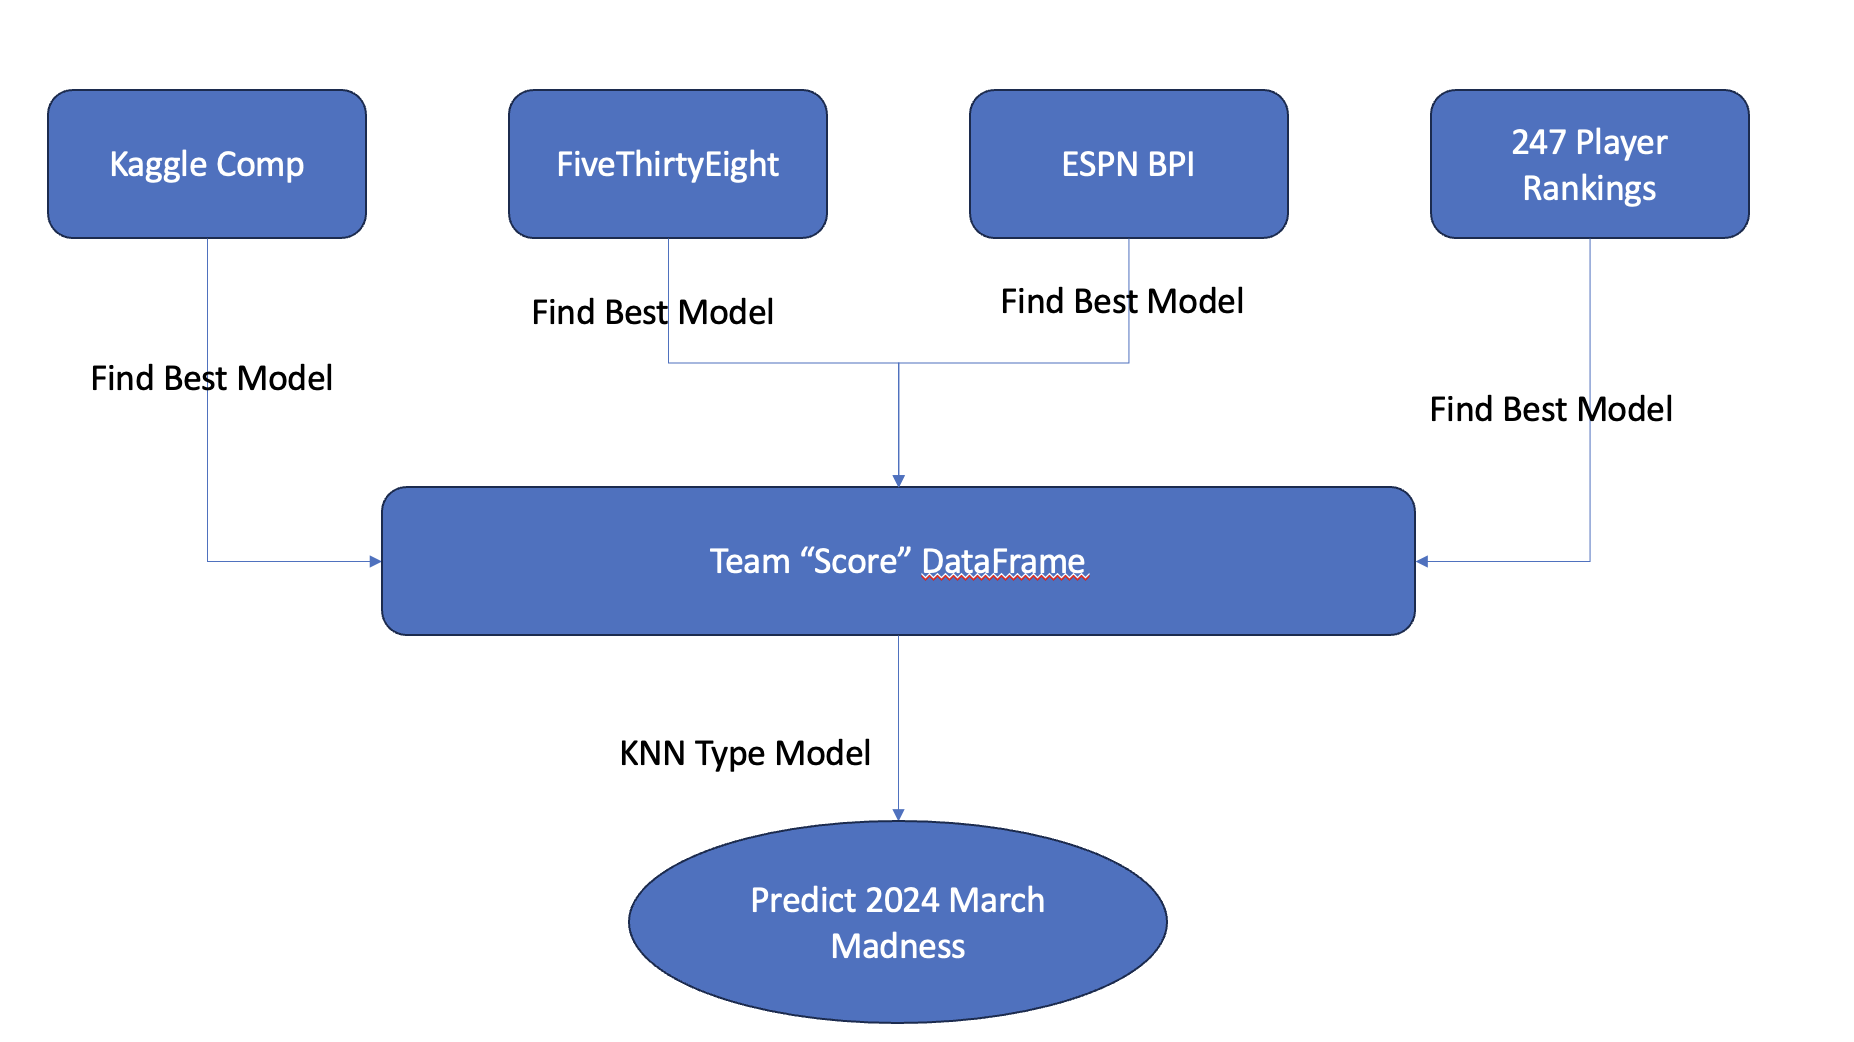